In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from urllib.parse import unquote
import numpy as np
import os
import seaborn as sns

import networkx as nx

### Reading data frames into dictionary

In [2]:
def reading_filenames(input_dir):
    files = [f for f in os.listdir(input_dir) if f.endswith('.tsv') or f.endswith('.txt')]

    return files

In [3]:
data_folder = 'data/wikispeedia_paths-and-graph/'
file_names = reading_filenames(data_folder)

In [4]:
print(file_names)

['shortest-path-distance-matrix.txt', 'paths_finished.tsv', 'articles.tsv', 'paths_unfinished.tsv', 'links.tsv', 'categories.tsv']


In [5]:
dataframes = {}

#Reading files in dictionary
for file in file_names:
    try:
        if file.endswith('.tsv'):
            df = pd.read_csv(data_folder + file, sep='\t', comment='#', header = None, encoding="utf-8")
        else:
            df = pd.read_csv(data_folder + file, sep=',', comment='#', header = None, encoding="utf-8")
        
        dataframes[file.split('.')[0]] = df
    except pd.errors.ParserError as e:
        print(f"Could not parse {file}: {e}")

In [6]:
print(dataframes.keys())

dict_keys(['shortest-path-distance-matrix', 'paths_finished', 'articles', 'paths_unfinished', 'links', 'categories'])


### Links data
Cleaning up link data

In [7]:
dataframes['links'] = dataframes['links'].rename(columns={0: "linkSource", 1: "linkTarget"})

In [8]:
dataframes["links"]["linkSource"] = dataframes["links"]["linkSource"].apply(unquote)
dataframes["links"]["linkTarget"] = dataframes["links"]["linkTarget"].apply(unquote)

In [9]:
dataframes['links'].head(10)

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
5,Áedán_mac_Gabráin,Isle_of_Man
6,Áedán_mac_Gabráin,Monarchy
7,Áedán_mac_Gabráin,Orkney
8,Áedán_mac_Gabráin,Picts
9,Áedán_mac_Gabráin,Scotland


### Categories data
Cleaning up categories data

In [10]:
#Renaming columns
dataframes['categories'] = dataframes['categories'].rename(columns={0: "article", 1: "category"})

In [11]:
#Decoding article names
dataframes["categories"]["article"] = dataframes["categories"]["article"].apply(unquote)

In [12]:
#Splitting categories into sub categories
split_columns = dataframes["categories"]['category'].str.split('.', expand=True)

#Dropping first column which only contains the word subject
split_columns = split_columns.drop(0, axis=1)
split_columns.head()


,1,2,3
0,History,British_History,British_History_1500_and_before_including_Roma...
1,People,Historical_figures,None
2,Countries,None,None
3,Geography,European_Geography,European_Countries
4,People,Artists,None


In [13]:
#Joining with original dataframe
dataframes["categories"] = dataframes["categories"].join(split_columns)

In [14]:
dataframes["categories"].head(10)

,article,category,1,2,3
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán_mac_Gabráin,subject.People.Historical_figures,People,Historical_figures,None
2,Åland,subject.Countries,Countries,None,None
3,Åland,subject.Geography.European_Geography.European_...,Geography,European_Geography,European_Countries
4,Édouard_Manet,subject.People.Artists,People,Artists,None
5,Éire,subject.Countries,Countries,None,None
6,Éire,subject.Geography.European_Geography.European_...,Geography,European_Geography,European_Countries
7,Óengus_I_of_the_Picts,subject.History.British_History.British_Histor...,History,British_History,British_History_1500_and_before_including_Roma...
8,Óengus_I_of_the_Picts,subject.People.Historical_figures,People,Historical_figures,None
9,€2_commemorative_coins,subject.Business_Studies.Currency,Business_Studies,Currency,None


In [15]:
categories_ha = np.unique(dataframes["categories"][1])
print(categories_ha)

['Art' 'Business_Studies' 'Citizenship' 'Countries'
 'Design_and_Technology' 'Everyday_life' 'Geography' 'History' 'IT'
 'Language_and_literature' 'Mathematics' 'Music' 'People' 'Religion'
 'Science']


### Cleaning up articles data

In [16]:
dataframes["articles"].head()

,0
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


In [17]:
#Renaming columns
dataframes['articles'] = dataframes['articles'].rename(columns={0: "article_name",})

In [18]:
dataframes["articles"]["article_name"] = dataframes["articles"]["article_name"].apply(unquote)

In [19]:
dataframes["articles"].head()

,article_name
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


### Cleaning up shortest path data

In [20]:
dataframes['shortest-path-distance-matrix'].head()

,0
0,0_____33333325634333435_2433544334_3_422343544...
1,_0____22222325623232424_2422544324_3_312242544...
2,__0___33222425623232324_2333444433_3_422343434...
3,___0__33333325634233334_2433434333_2_423343433...
4,____0_22323335633332435_2433545434_3_423343544...


In [21]:
def convert_string_to_int(cell):

    return [int(char) if char.isdigit() else np.nan for char in cell]
    
# Apply the function to each cell, expand each string into separate columns
df_shortest_path = dataframes['shortest-path-distance-matrix'][0].apply(convert_string_to_int)

In [22]:
df_shortest_path.head()

0    [0, nan, nan, nan, nan, nan, 3, 3, 3, 3, 3, 3,...
1    [nan, 0, nan, nan, nan, nan, 2, 2, 2, 2, 2, 3,...
2    [nan, nan, 0, nan, nan, nan, 3, 3, 2, 2, 2, 4,...
3    [nan, nan, nan, 0, nan, nan, 3, 3, 3, 3, 3, 3,...
4    [nan, nan, nan, nan, 0, nan, 2, 2, 3, 2, 3, 3,...
Name: 0, dtype: object

### Cleaning up paths finished data
Has anyone code for this?

### Cleaning up paths unfinished data
Has anyone code for this?

### Creating "Hubs" data frame 
Where each article is and has: 
1. The number of links from them 
2. The number of links to them 
3. The average shortest path to them 
4. The average shortest path from them 
5. Their main subject or main subjects if they have more than one


In [23]:
df_hubs = pd.DataFrame()
df_hubs["article_names"] = dataframes["articles"]["article_name"]

In [24]:
#Printing wikipages with most links
source_counts = dataframes["links"]['linkSource'].value_counts()
df_hubs["source_counts"] = df_hubs["article_names"].map(source_counts).fillna(0).astype(int)

target_counts = dataframes["links"]['linkTarget'].value_counts()
df_hubs["target_counts"] = df_hubs["article_names"].map(target_counts).fillna(0).astype(int)

In [25]:
#Adding average shortest path distance
def count_mean(row):
    return np.nanmean(row)

#Counting nan values 
def count_nans_in_list(row):
    return sum(pd.isna(item) for item in row)

#Count specific number
def count_distance_in_list(row, distance = 1):
    return sum(item == distance for item in row)

In [26]:
#Mean taking nan values into account
df_shortest_path_mean =  df_shortest_path.apply(count_mean)

In [27]:
df_hubs["mean_shortest_path"] = df_shortest_path_mean

In [28]:
df_hubs.head()

,article_names,source_counts,target_counts,mean_shortest_path
0,Áedán_mac_Gabráin,11,0,3.395464
1,Åland,19,0,3.127959
2,Édouard_Manet,20,0,3.171598
3,Éire,8,0,3.325937
4,Óengus_I_of_the_Picts,10,0,3.386834


In [29]:
#I think some of the articles with almost no shortest path are only connected with 1 other article
#df_hubs["nan_count"] = df_shortest_path.apply(count_nans_in_list)
#df_hubs["one_count"] = df_shortest_path.apply(count_distance_in_list)

In [30]:
df_hubs.head()

,article_names,source_counts,target_counts,mean_shortest_path
0,Áedán_mac_Gabráin,11,0,3.395464
1,Åland,19,0,3.127959
2,Édouard_Manet,20,0,3.171598
3,Éire,8,0,3.325937
4,Óengus_I_of_the_Picts,10,0,3.386834


In [31]:
#Some articles belong to more than 1 category
print(len(dataframes["categories"]))
print(len(dataframes["articles"]))


5204
4604


In [36]:
#Adding subjects to articles
categories = np.unique(dataframes["categories"][1])
print(categories)

['Art' 'Business_Studies' 'Citizenship' 'Countries'
 'Design_and_Technology' 'Everyday_life' 'Geography' 'History' 'IT'
 'Language_and_literature' 'Mathematics' 'Music' 'People' 'Religion'
 'Science']


In [46]:
df_hubs.head()

,article_names,source_counts,target_counts,mean_shortest_path,Art,Business_Studies,Citizenship,Countries,Design_and_Technology,Everyday_life,Geography,History,IT,Language_and_literature,Mathematics,Music,People,Religion,Science
0,Áedán_mac_Gabráin,11,0,3.395464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Åland,19,0,3.127959,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,Édouard_Manet,20,0,3.171598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Éire,8,0,3.325937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Óengus_I_of_the_Picts,10,0,3.386834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# Add a column for each category in categories_ha
for category in categories:
    articles_in_category = dataframes["categories"].loc[dataframes["categories"][1] == category, 'article']
    df_hubs[category] = np.where(df_hubs['article_names'].isin(articles_in_category), 1, 0)

In [68]:
df_hubs.head()

,article_names,source_counts,target_counts,mean_shortest_path,Art,Business_Studies,Citizenship,Countries,Design_and_Technology,Everyday_life,Geography,History,IT,Language_and_literature,Mathematics,Music,People,Religion,Science
0,Áedán_mac_Gabráin,11,0,3.395464,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,Åland,19,0,3.127959,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,Édouard_Manet,20,0,3.171598,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Éire,8,0,3.325937,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,Óengus_I_of_the_Picts,10,0,3.386834,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


### Calculating some basic statistics

We need to show:\
That you understand what’s in the data (formats, distributions, missing values, correlations, etc.) \
That you considered ways to enrich, filter, transform the data according to your needs.

<Axes: >

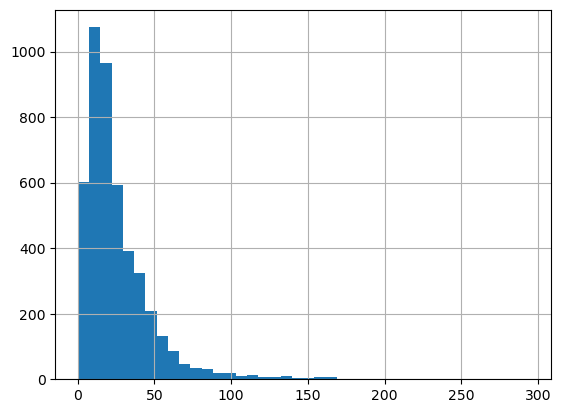

In [73]:
#Plotting distribution of links on wikipages
df_hubs["source_counts"].hist(bins = 40)

<Axes: >

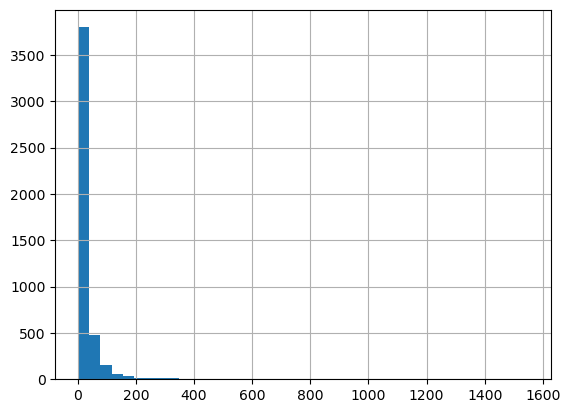

In [74]:
#Plotting distribution of links to wikipages
df_hubs["target_counts"].hist(bins = 40)

<Axes: >

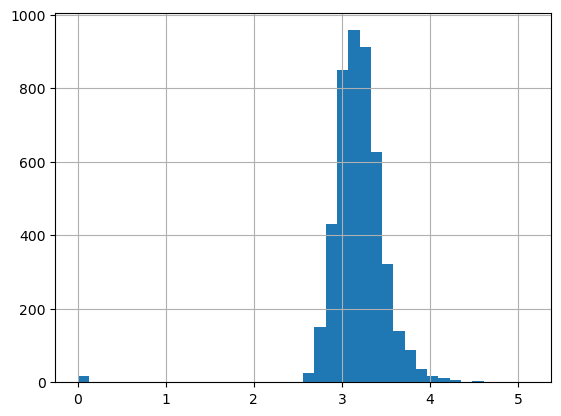

In [ ]:
#Do in reverse! 
df_hubs["mean_shortest_path"].hist(bins = 40)

#Boxplot? 

<Axes: >

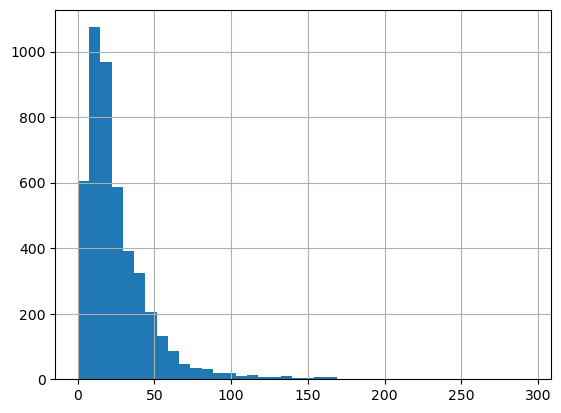

In [78]:
df_hubs["one_count"].hist(bins = 40)

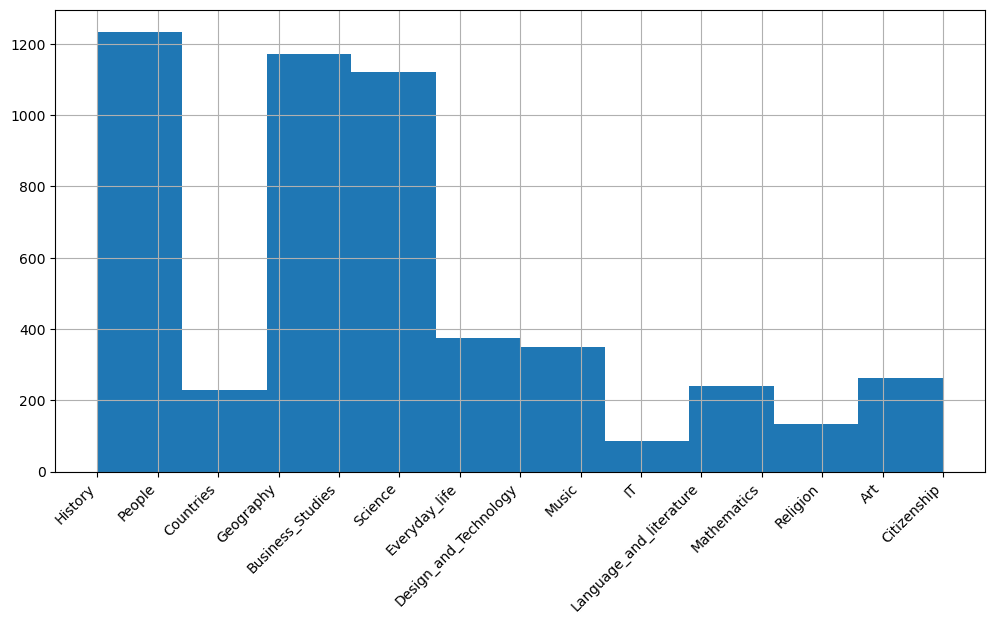

In [ ]:
#Compare most common articles in wikipidia
#With most visited articles in the game

fig = plt.figure(figsize=(12, 6))
dataframes["categories"][1].hist()
plt.xticks(rotation=45, ha='right')
plt.show()

### Plotting scatter plot

In [83]:
#print(categories)
df_hubs.head()

,article_names,source_counts,target_counts,mean_shortest_path,Art,Business_Studies,Citizenship,Countries,Design_and_Technology,Everyday_life,Geography,History,IT,Language_and_literature,Mathematics,Music,People,Religion,Science,subject_count
0,Áedán_mac_Gabráin,11,0,3.395464,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2
1,Åland,19,0,3.127959,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,2
2,Édouard_Manet,20,0,3.171598,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,Éire,8,0,3.325937,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,2
4,Óengus_I_of_the_Picts,10,0,3.386834,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2


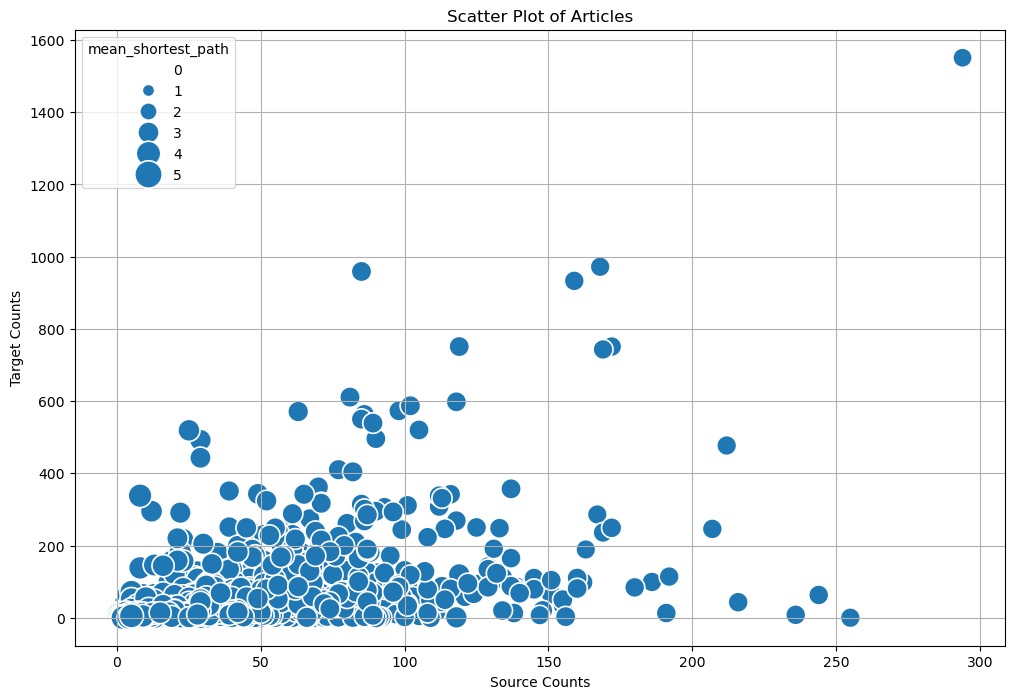

In [101]:
# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_hubs,
    x='source_counts',
    y='target_counts',
    size='mean_shortest_path',
    sizes=(2, 400)
)

#plt.xscale('log')
#plt.yscale('log')
plt.title('Scatter Plot of Articles')
plt.xlabel('Source Counts')
plt.ylabel('Target Counts')
plt.grid(True)
plt.show()

### Exploring Shortest path data

In [69]:
df_hubs.head()

,article_names,source_counts,target_counts,mean_shortest_path,Art,Business_Studies,Citizenship,Countries,Design_and_Technology,Everyday_life,Geography,History,IT,Language_and_literature,Mathematics,Music,People,Religion,Science
0,Áedán_mac_Gabráin,11,0,3.395464,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,Åland,19,0,3.127959,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,Édouard_Manet,20,0,3.171598,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Éire,8,0,3.325937,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,Óengus_I_of_the_Picts,10,0,3.386834,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [33]:
min_value = df_expanded_mean.min()

min_indices = df_expanded.index[df_expanded_mean == min_value].tolist()

print(min_indices)

[441, 970, 1210, 1231, 1237, 1257, 2351, 2530, 2543, 3108, 3352, 3645, 3928, 4289, 4333, 4480, 4545]


In [35]:
#I think some of the articles with almost no shortest path are only connected with 1 other article
nan_count = df_expanded.iloc[min_indices].apply(count_nans_in_list)
one_count = df_expanded.iloc[min_indices].apply(count_ones_in_list)

In [36]:
print('Printing articles with min distance 0.0')
dataframes["articles"].iloc[min_indices]

Printing articles with min distance 0.0


,article_name
441,Badugi
970,Color_Graphics_Adapter
1210,Directdebit
1231,Donation
1237,Douglas_DC-4
1257,Duchenne_muscular_dystrophy
2351,Klinefelter's_syndrome
2530,Local_community
2543,Lone_Wolf_(gamebooks)
3108,Osteomalacia


This menas these articles have no connection to other articles! Not that they have short distances to all other articles!

In [37]:
df_expanded = df_expanded.drop(min_indices, axis = 0)
expanded_mean =  df_expanded.apply(lambda x: np.nanmean(x))

In [39]:
expanded_mean = expanded_mean.sort_values(ascending=True)
articles_small_mean = dataframes["articles"].iloc[expanded_mean[0:20].index]


In [40]:
#Printing articles with smallest mean
articles_small_mean

,article_name
1600,Friend_Directdebit
3849,Sponsorship_Directdebit
4297,United_States
39,21st_century
1989,History_of_the_world
331,Argentina
24,19th_century
4293,United_Kingdom
1247,Driving_on_the_left_or_right
128,Africa


Interesting results! Look at these/this more. They are not all overlapping with the most number of links. Some might be to not connected to other articles since we are using nan means. But other are probably because they are hubs!

Hubs!?: \
United States \
21st_centry \
History of the world \
Argentina \
19_th century \
United Kingdom \
Driving to the left or right \
Africa \
Swastika...

### Looking at the mean shortest path distance grouped by subject

### Calculate how many subjects a given article is connected to

### Calculate information gain by moving to a hub?

### Creating graph plot over links and giving color by subject

Tried to create a connected graph visualization. Not very happy with it! Unsure if this is a good way to do it. \
Ideas:
- Would be cool with a visualization that shows all pages with 1 link, 2 links, 3 links ... be removed 
- Can we look at the major hubs only?
- Something density based?? 


In [ ]:
indices = dataframes["links"].index[dataframes["links"]['linkSource'] == 'Water'].tolist()
print(indices)


In [ ]:
G = nx.from_pandas_edgelist(dataframes["links"].iloc[indices], source='linkSource', target='linkTarget')
pos = nx.circular_layout(G)

In [ ]:
print(dataframes["categories"][1].unique())

In [ ]:
color_list = [
    'blue',        # History
    'orange',      # People
    'green',       # Countries
    'red',         # Geography
    'purple',      # Business Studies
    'cyan',        # Science
    'magenta',     # Everyday Life
    'yellow',      # Design and Technology
    'brown',       # Music
    'pink',        # IT
    'lightblue',   # Language and Literature
    'lime',        # Mathematics
    'gold',        # Religion
    'violet',      # Art
    'black'         # Citizenship
]

In [ ]:
#Note: Make so that articles with several subjects have a special color??
color_map = {category: color for category, color in zip(dataframes["categories"][1].unique(), color_list)}
print(color_map)

node_colors = []

for node in G.nodes:

    result = dataframes['categories'][dataframes['categories']['article'] == node][1]

    if not result.empty:
        category = result.values[0]  # Get the first category value
        
        node_colors.append(color_map.get(category, "grey"))
    else:
        node_colors.append("grey")
    

In [ ]:
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed

# Adjust the spring layout
pos = nx.spring_layout(G, seed=10, k=0.5)  # Increase 'k' to space out nodes more

# Nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors)  # Increase node size for visibility

# Edges
nx.draw_networkx_edges(G, pos, width=0.1)  # Increase edge width for better visibility

# Create legend handles
legend_handles = [mpatches.Patch(color=color_map[category], label=category) for category in color_map]

# Add legend to the plot
plt.legend(handles=legend_handles, title="Categories", loc='upper right')

# Layout adjustments
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.tight_layout()

plt.show()

In [ ]:
#Look at the density of the network!!